## 利用神经网络Logistic回归来识别猫

### 数据准备

这里的问题就是想通过一个模型来判别给出的图片是否为猫。
- 图片的shape(width,hight,3),RGB的图片
- 这里的图片数据是保存在一个“data.h5”的文件中

这里需要导入的库有：
- numpy：这个不用介绍
- h5py 用来分析H5 文件的包.
- matplotlib 不用介绍
- PIL and scipy 用来分析最后的预测结果.


In [ ]:
# 这里是关于lr_utilsj脚步的coding
"""
import numpy as np
import h5py
    
    
def load_dataset():
    train_dataset = h5py.File('./datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
"""


In [1]:
# 导入的库
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
# 这个是作者自己写的一个脚步文件用来获取数据集的信息
from lr_utils import load_dataset

%matplotlib inline


现在开始来获取训练集和测试集。就是利用上面的给的脚本函数：
- train_set_x_orig ： 训练集orig,表示原始数据，后面我们要对原始数据进行归一化等处理
- traing_set_y：训练集标签
- test_set_x_orig：测试集orig,表示原始数据
- test_set_y：测试集标签
- classes：种类

这些数据的格式通过shape函数就可以获得：
- train_set_x_orig：(209, 64, 64, 3)
    - 209：表示训练样本的个数
    - (64, 64, 3):表示图片size 和channel
- traing_set_y：(1, 209)
- test_set_x_orig：(50, 64, 64, 3)
- test_set_y：(1, 50)
- classes：(2,)
    - non-cat
    - cat

In [20]:
#获取数据集
train_set_x_orig,train_set_y,test_set_x_orig,test_set_y, classes= load_dataset()

In [21]:
# 训练集的一些信息
# (209, 64, 64, 3):
print(train_set_x_orig.shape)
print(train_set_y.shape)
print(test_set_x_orig.shape)
print(test_set_y.shape)
print(classes.shape)
print(classes[0])
print(classes[1])
print(type(classes))

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)
(2,)
b'non-cat'
b'cat'
<class 'numpy.ndarray'>


#### 几个知识点

**numpy.squeeze(a, axis=None)**

squeeze()函数的功能是：从矩阵shape中，去掉维度为1的。例如一个矩阵是的shape是（5， 1），使用过这个函数后，结果为（5，）

>参数：
a是输入的矩阵
axis : 选择shape中的一维条目的子集。如果在shape大于1的情况下设置axis，则会引发错误。


In [22]:
# numpy.squeeze 案例
c = np.arange(10).reshape(1,10)
print(c)
print(c.shape)
print("使用squeeze后")
sc = np.squeeze(c)
print(sc)
print(sc.shape)

[[0 1 2 3 4 5 6 7 8 9]]
(1, 10)
使用squeeze后
[0 1 2 3 4 5 6 7 8 9]
(10,)


 **decode**
 
 Python decode() 方法以 encoding 指定的编码格式解码字符串。默认编码为字符串编码
 
 str.decode(encoding='UTF-8',errors='strict')  
 
 >encoding -- 要使用的编码，如"UTF-8"。
errors -- 设置不同错误的处理方案。默认为 'strict',意为编码错误引起一个UnicodeError。 其他可能得值有 'ignore', 'replace', 'xmlcharrefreplace', 'backslashreplace' 以及通过 codecs.register_error() 注册的任何值。

可以看看没有decode解码的输出状态是不一样的。
 

y= [0] non-cat
y= [0] b'non-cat'


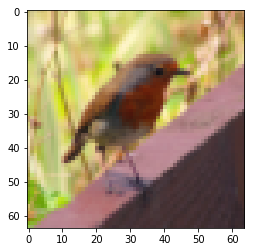

In [24]:
# 显示一张图
index = 10
plt.imshow(train_set_x_orig[index])
print("y=",str(train_set_y[:,index]),classes[np.squeeze(train_set_y[:, index])].decode("utf-8"))
# 没有使用decode
print("y=",str(train_set_y[:,index]),classes[np.squeeze(train_set_y[:, index])])

#### 数据转换

将图片的3D数据转换成1D数据，这样方便使用神经网络的输入。
使用reshape可以很方便的做到：
`X_flatten = X.reshape(X.shape[0],-1).T`
这里的意思是保留第一位数据，-1,：表示到最后的一位变成一个列数据

In [31]:
# reshap的使用
c = np.arange(60).reshape(2,3,10)
print(c)
d = c.reshape(c.shape[0],-1)
print(d.shape)
print(d)


[[[ 0  1  2  3  4  5  6  7  8  9]
  [10 11 12 13 14 15 16 17 18 19]
  [20 21 22 23 24 25 26 27 28 29]]

 [[30 31 32 33 34 35 36 37 38 39]
  [40 41 42 43 44 45 46 47 48 49]
  [50 51 52 53 54 55 56 57 58 59]]]
(2, 30)
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
  54 55 56 57 58 59]]


In [25]:
# 变换数据
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

# 这里的.T表示转置，为了与后面的W相匹配，也方便大家理解输入的神经元
train_set_x_flat = train_set_x_orig.reshape(m_train,-1).T
test_set_x_flat = test_set_x_orig.reshape(m_test,-1).T

print(train_set_x_flat.shape)
print(test_set_x_flat.shape)


(12288, 209)
(12288, 50)


#### 数据的归一化

由于图片的数据是由RGB3个通道组成，且通道的数据范围为0-255，为了方便以后的计算，每次我们都需要对输入的原始数据进行归一化。具体实践如下


In [26]:
#### 数据的归一化
train_set_x = train_set_x_flat/255.
test_set_x = test_set_x_flat/255.

### 简单模型的搭建

该模型的使用一层神经网络进行搭建，具体的模型的框架如下图：

![](imgs/5.jpg)

模型中用到的公式如下：
![](imgs/6.jpg)

模型搭建的过程：
- 定义模型的框架
- 初始化模型中用到的参数
- 训练参数
    - 前向计算
    - 反向计算
    - 更新参数

#### 辅助函数定义

定义sigmoid函数


In [27]:
#定义sigmoid函数
def sigmoid(x):
    
    return 1.0/(1.0 + np.exp(-x))

#### 初始化参数

这里为了简单，只需要将数据默认设置为0,

In [28]:
def init_para_zeros(dim):
    """
    dim:表示输入数据的维度
    """
    w = np.zeros((dim,1))
    b = 0
    
    return w,b
    

In [4]:
dim =3
print(init_para_zeros(dim))

(array([[0.],
       [0.],
       [0.]]), 0)


#### 前向神经和反向网络计算

前向网络计算的过程，就是利用上面的公式进行相关的计算，反向计算是需要计算该次的梯度值：具体的公式如下
![](imgs/7.jpg)

相应的coding如下



In [29]:
def propagate(w,b,X,Y):
    """
    计算损失值，以及反向传播的dw,db的值
    """
    
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T,X)+b)
    cost = np.sum(Y*np.log(A)+(1-Y)*np.log(1-A)) * (-1.0/m)
    
    dw = (1.0/m) * np.dot(X,((A-Y).T))
    db = (1.0/m) * np.sum(A-Y)
    
    cost = np.squeeze(cost)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads,cost
    

In [30]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))


dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


#### 优化参数

上面我们计算了每次迭代的cost值，下面我们要利用上面计算的值进行参数优化，主要等公式如下：  
 $θ=θ−αdθ$
具体的coding如下：


In [31]:
def optimize(w,b,X,Y,num_iterations,learning_rate,print_cost=False):
    
    costs = []
    
    # 迭代的次数
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        # 更新参数的值
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # 记录cost值：
        if i % 100 == 0:
            costs.append(cost)
        
        # 打印cost值
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
        
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs
                

        

In [32]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))


w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652


#### 预测函数

这里的预测函数是基于上面的计算而得到的w,b的参数来定的，通过上面的优化，我们可以获得这些参数，然后利用这些参数来计算，需要判断的图片是否存在。
这里sigmoid的计算结果我们可以通过这样的计算来获得，最终的判断是：该值>0.5来判断该分类。



In [33]:
def predict(w,b,X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    # 转换为2维的方式
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
            
    return Y_prediction
            

In [19]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))


predictions = [[1. 1. 0.]]


### 神经网络模型训练与测试

通过上面的一些函数的定义，下面我们可以定整个模型了



In [35]:
def model(X_train,Y_train,X_test,Y_test,num_iterations=2000,learning_rate=0.5,print_cost=False):
    
    # 参数初始化
    w,b = init_para_zeros(X_train.shape[0])
    
    # 参数优化
    parameters,grads,costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    
    # 获得参数
    w = parameters["w"]
    b = parameters["b"]
    
    # 通过网络预测图片
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)
    
    # 计算精度
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

    


In [36]:
#训练模型
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


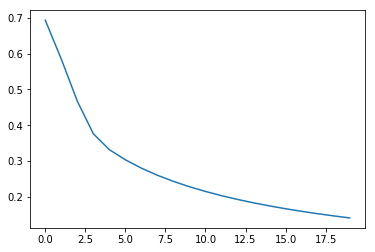

In [37]:
# 绘制曲线
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



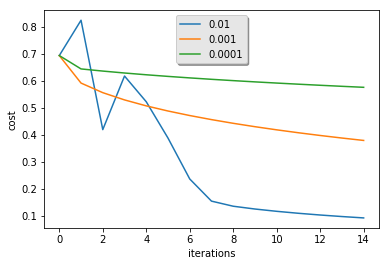

In [38]:
#对于不同的学习率的计算
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()


D:\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
D:\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':


y = 1.0, your algorithm predicts a "cat" picture.


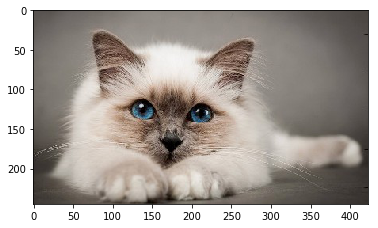

In [40]:
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "test.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "imgs/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
# 对图片进行尺寸的压缩
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
# 预测模型
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")
